# Community Detection

_UNDER CONSTRUCTION_

- Community Detection and Industry Sectoring
- TNIC (Text-based Network Industry Classification), see Hoberg and Phillips (2016)


In [1]:
import zipfile
import io
import time
from itertools import chain
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import networkx.algorithms.community as nx_comm
from finds.database import SQL
from finds.readers import requests_get, Sectoring
from finds.busday import BusDay
from finds.structured import PSTAT
from finds.misc import Show
from finds.graph import graph_info, community_quality, community_detection
from secret import credentials, paths
# %matplotlib qt
VERBOSE = 0
show = Show(ndigits=4, latex=False)

In [2]:
sql = SQL(**credentials['sql'], verbose=VERBOSE)
bd = BusDay(sql)
pstat = PSTAT(sql, bd, verbose=VERBOSE)
imgdir = paths['images'] / 'tnic'  # None
tnic_scheme = 'tnic3'

Last FamaFrench Date 2023-06-30 00:00:00


Retrieve TNIC scheme from Hoberg and Phillips website

In [3]:
## https://hobergphillips.tuck.dartmouth.edu/industryclass.htm
root = 'https://hobergphillips.tuck.dartmouth.edu/idata/'   
source = root + tnic_scheme + '_data.zip'
if source.startswith('http'):
    response = requests_get(source)
    source = io.BytesIO(response.content)
with zipfile.ZipFile(source).open(tnic_scheme + "_data.txt") as f:
    tnic_data = pd.read_csv(f, sep='\s+')
tnic_data

,year,gvkey1,gvkey2,score
0,1988,1011,3226,0.1508
1,1988,1011,6282,0.0851
2,1988,1011,6734,0.0258
3,1988,1011,7609,0.0097
4,1988,1011,9526,0.0369
...,...,...,...,...
25657913,2021,345556,345556,NaN
25657914,2021,345920,345920,NaN
25657915,2021,345980,345980,NaN
25657916,2021,347007,347007,NaN


Modularity of sectoring schemes 1989
------------------------------------
         communities  modularity  coverage  performance
bea1947           42      0.1534    0.6464       0.9307
bea1963           59      0.1901    0.4979       0.9515
bea1997           63      0.1884    0.4940       0.9525
codes10           10      0.1568    0.7480       0.8491
codes12           12      0.1614    0.7190       0.8821
codes17           17      0.1556    0.7027       0.8428
codes30           30      0.1538    0.6939       0.9156
codes38           37      0.1484    0.6794       0.9130
codes48           48      0.1987    0.5186       0.9560
codes49           49      0.1986    0.5177       0.9584
codes5             5      0.1595    0.7739       0.7900
sic2              69      0.1951    0.4958       0.9562
sic3             258      0.1985    0.2984       0.9696

3.0 secs: label_propogation
5.0 secs: louvain
38.0 secs: greedy
total elapsed: 0.0 label
total elapsed: 1.0 louvain
total elapsed: 1.0 greedy

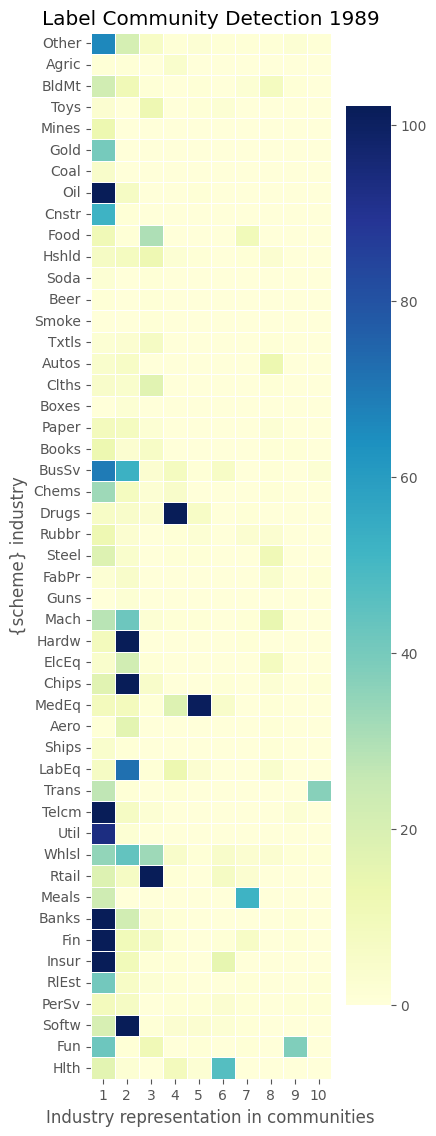

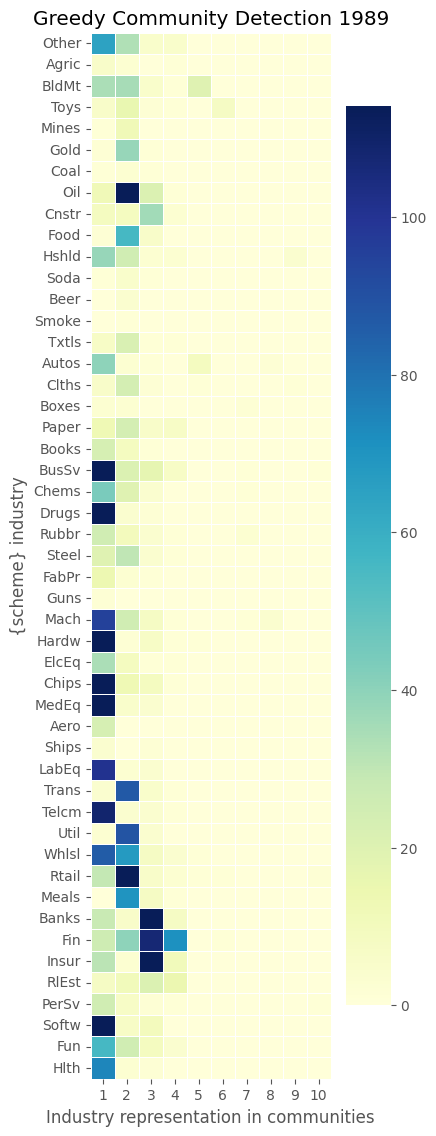

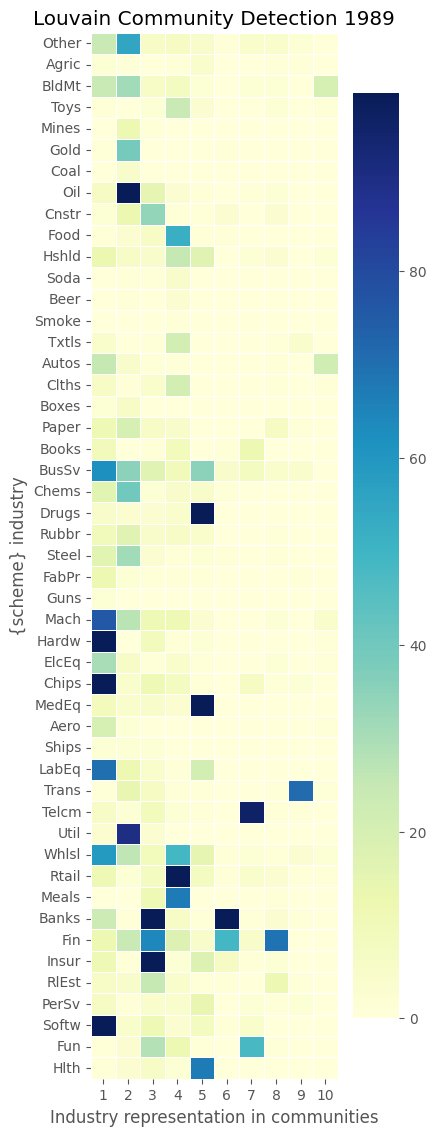

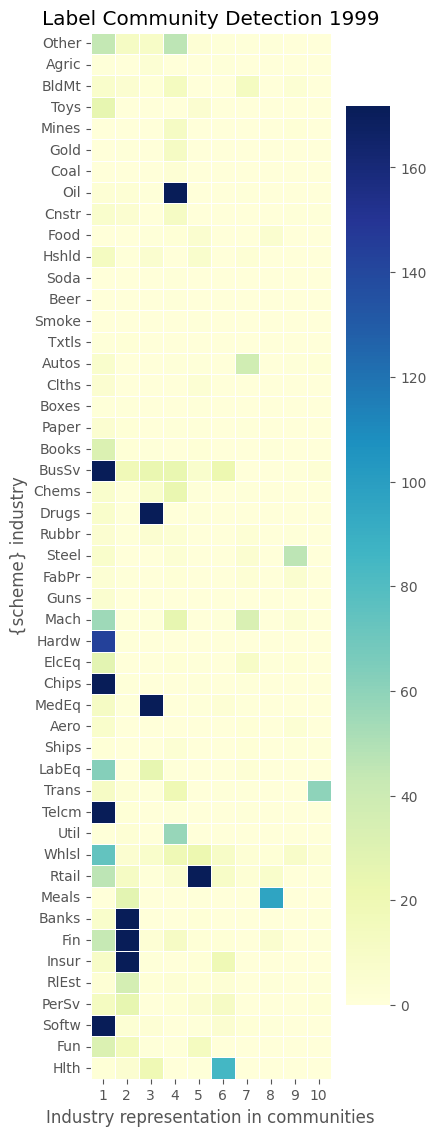

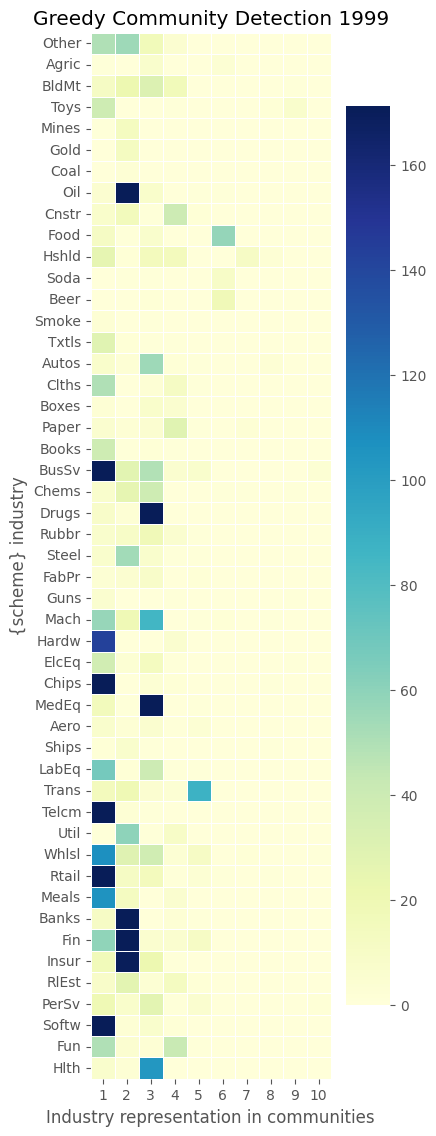

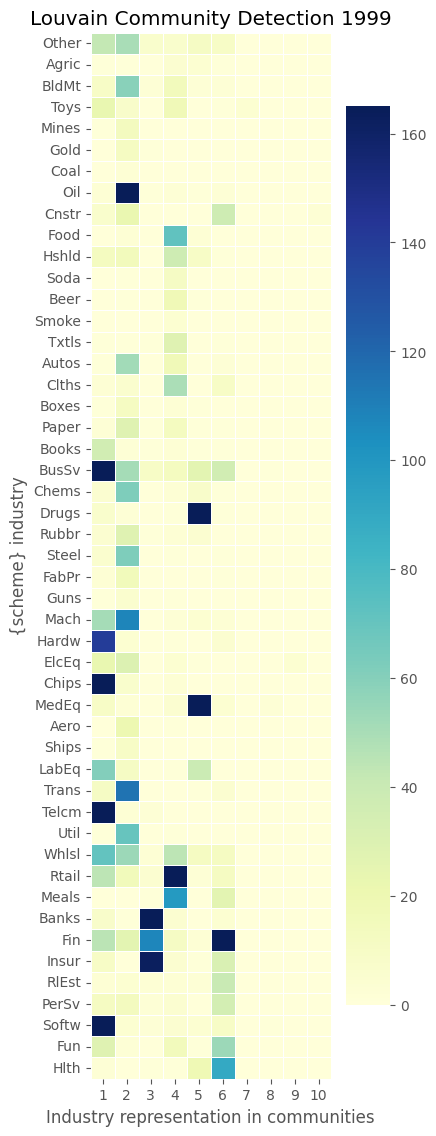

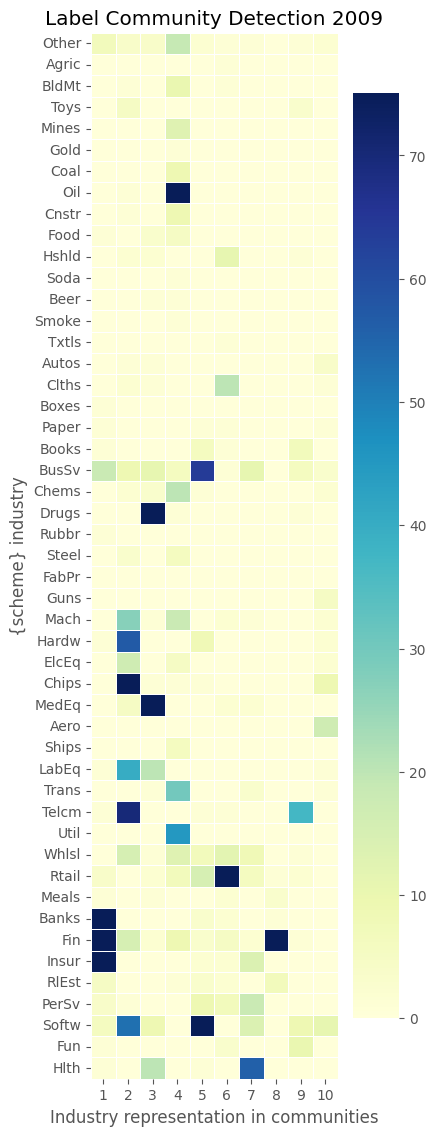

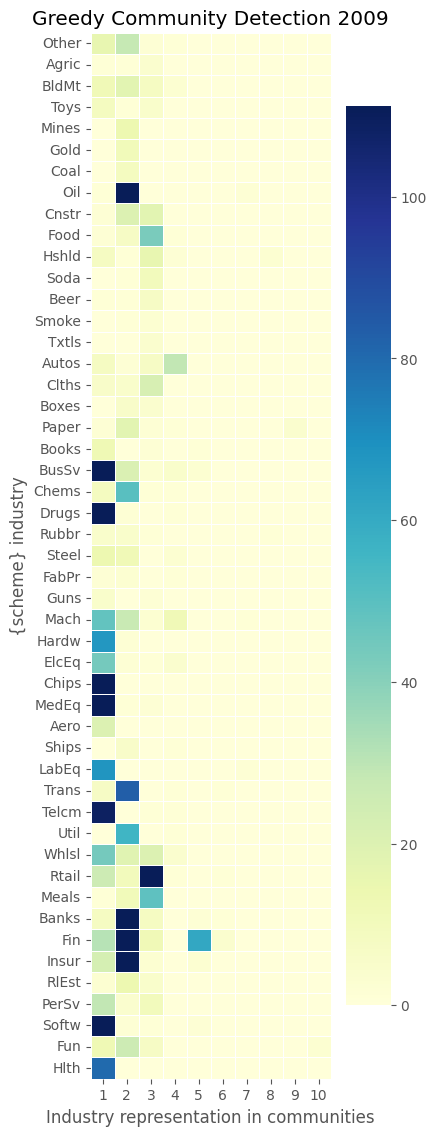

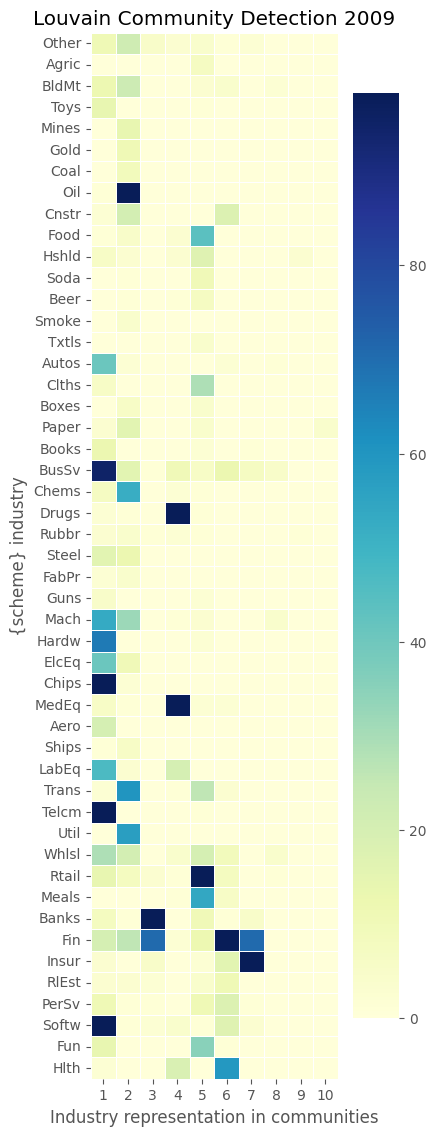

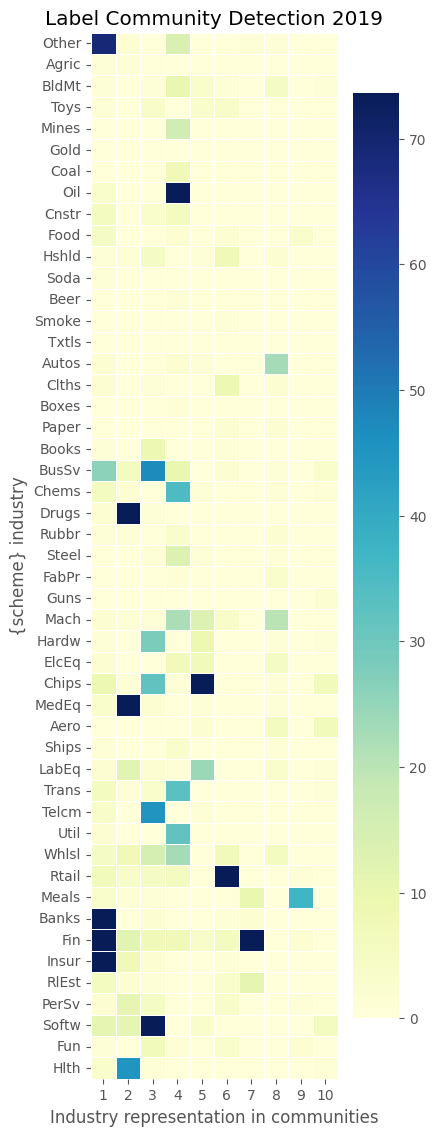

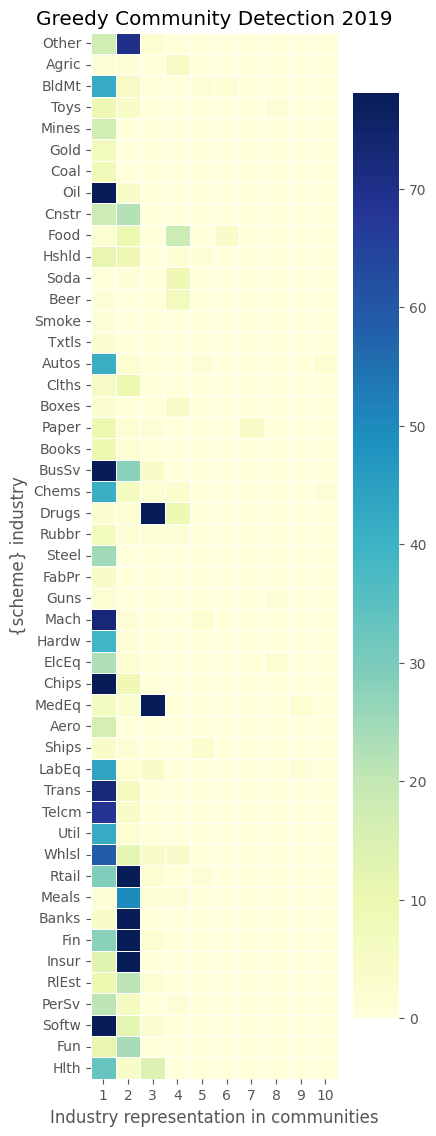

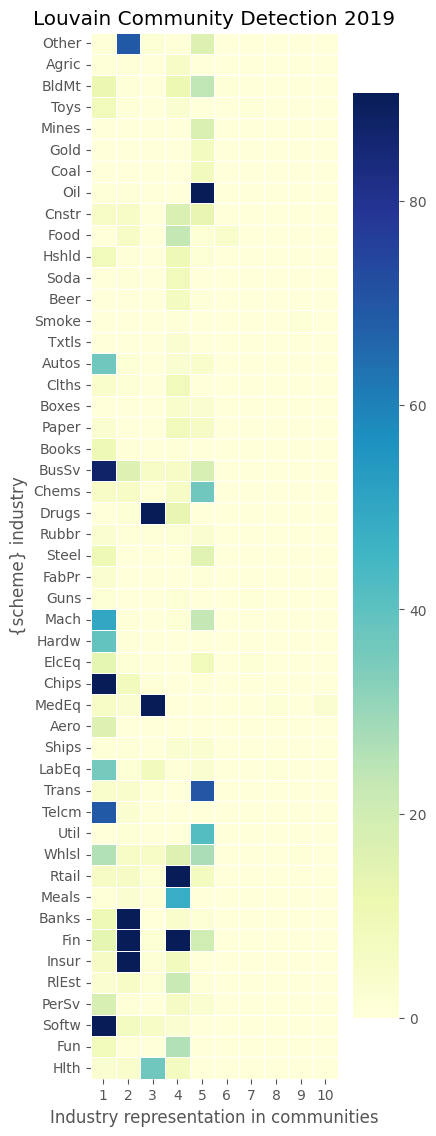

In [4]:
# Loop over representative years for community detection
years = [1989, 1999, 2009, 2019]  # [1999, 2019]:
collect = {'info': {}, 'modularity': {}, 'community': {}}  # to collect metrics
num = 0
for year in years:
    
    # extract one year of tnic as data frame
    tnic = tnic_data[tnic_data.year == year].dropna()
    nodes = DataFrame(index=sorted(set(tnic['gvkey1']).union(tnic['gvkey2'])))

    # with gvkey, lookup permno, sic and naics codes
    for code in ['lpermno', 'sic', 'naics']:
        lookup = pstat.build_lookup('gvkey', code, fillna=0)
        nodes[code] = lookup(nodes.index)
    naics = Sectoring(sql, 'naics', fillna=0)   # supplement from crosswalk
    sic = Sectoring(sql, 'sic', fillna=0)
    nodes['naics'] = nodes['naics'].where(nodes['naics'] > 0,
                                            naics[nodes['sic']])
    nodes['sic'] = nodes['sic'].where(nodes['sic'] > 0,
                                        naics[nodes['naics']])
    Series(np.sum(nodes > 0, axis=0)).rename('Non-missing').to_frame().T

    # apply sectoring schemes, and store in nodes DataFrame
    schemes = {'sic': ([f"codes{c}" for c in [5, 10, 12, 17, 30, 38, 48, 49]]
                       + ['sic2', 'sic3']),
               'naics': ['bea1947', 'bea1963', 'bea1997']}
    codes = {}   # intermediate to combine raw sic/naics to sector scheme
    for key, sub in schemes.items():
        for scheme in sub:
            if scheme not in codes:
                fillna = 0 if scheme.startswith('sic') else ''
                codes[scheme] = Sectoring(sql, scheme, fillna=fillna)
                nodes[scheme] = codes[scheme][nodes[key]]
            nodes = nodes[nodes[scheme].ne(codes[scheme].fillna)]
    nodes

    # create edges
    edges = tnic[tnic['gvkey1'].isin(nodes.index) &
                 tnic['gvkey2'].isin(nodes.index)]
    edges = list(edges[['gvkey1', 'gvkey2', 'score']]\
                 .itertuples(index=False, name=None))

    # populate graph
    g = nx.Graph()
    g.add_weighted_edges_from(edges)

    # remove self-loops: not necessary
    g.remove_edges_from(nx.selfloop_edges(g))

    # graph info
    collect['info'][year] = Series(graph_info(g, fast=True)).rename(year)

    # Plot degree distribution
#    num = num + 1
#    fig, ax = plt.subplots(clear=True, num=num, figsize=(10,6))
#    Series(nx.degree_histogram(g)).hist(grid=False, ax=ax, bins=100)
#    ax.set_title(f'Degree Distribution of {tnic_scheme.upper()} links {year}')
#    plt.tight_layout(pad=3)
#    plt.savefig(os.path.join(imgdir, f'degree{year}' + figext))
    
    # evaluate modularity of sectoring schemes
    modularity = {}
    for scheme in sorted(chain(*schemes.values())):
        communities = nodes.loc[list(g.nodes), scheme]\
                           .reset_index()\
                           .groupby(scheme)['index']\
                           .apply(list)\
                           .to_list()    # list of list of symbols
        modularity[scheme] = community_quality(g, communities)
    df = DataFrame.from_dict(modularity, orient='index').sort_index()
    collect['modularity'][year] = df
    show(df, caption=f"Modularity of sectoring schemes {year}")

    # detect communities and report modularity
    communities = community_detection(g)
    tic = time.time()
    quality = {}
    for key, community in communities.items():
        quality[key] = community_quality(g, community)
        print('total elapsed:', round(time.time() - tic, 0), key)
    df = DataFrame.from_dict(quality, orient='index').sort_index()
    collect['community'][year] = df
    show(df, caption=f"Modularity community detection algorithms {year}")
    
    # Plot Fama-French codes49 industry representation as heatmap
    for ifig, detection in enumerate(['label', 'greedy', 'louvain']):
        scheme = 'codes49'
        industry = []
        for i, community in enumerate(sorted(communities[detection],
                                             key=len,
                                             reverse=True)):
            industry.append(nodes[scheme][list(community)]\
                            .value_counts()\
                            .rename(i+1))
            
        df = pd.concat(industry, axis=1)\
               .dropna(axis=0, how='all')\
               .fillna(0)\
               .astype(int)\
               .reindex(codes[scheme]\
                        .sectors['name']\
                        .drop_duplicates(keep='first'))

        num = num + 1
        fig, ax = plt.subplots(num=num, clear=True, figsize=(5, 12))
        sns.heatmap(df.iloc[:,:10],
                    square=False,
                    linewidth=.5,
                    ax=ax,
                    yticklabels=1,
                    cmap="YlGnBu",
                    robust=True)
        if scheme.startswith('bea'):
            ax.set_yticklabels(Sectoring._bea_industry[df.index], size=10)
        else:
            ax.set_yticklabels(df.index, size=10)
        ax.set_title(f'{detection.capitalize()} Community Detection {year}')
        ax.set_xlabel(f"Industry representation in communities")
        ax.set_ylabel('{scheme} industry')
        fig.subplots_adjust(left=0.4)
        plt.tight_layout(pad=3)
        plt.savefig(imgdir / f'{detection}_{year}.jpg')

Display latest year info

In [10]:
show(collect['info'][2019],
     caption=f"{tnic_scheme} {year} graph info:")

tnic3 2019 graph info:
----------------------
                            2019
connected                  False
connected_components          14
size_largest_component      3635
directed                   False
weighted                    True
negatively_weighted        False
edges                     318913
nodes                       3669
selfloops                      0
density                 0.047394



In [11]:
show(collect['community'][2019],
     caption=f"{tnic_scheme} {year} community detection:")

tnic3 2019 community detection:
-------------------------------
         communities  modularity  coverage  performance
greedy            26      0.4936    0.9775       0.7110
label             91      0.4951    0.9830       0.8971
louvain           21      0.4978    0.9848       0.8398



In [12]:
show(collect['modularity'][2019],
     caption=f"{year} modularity of industry sectoring crosswalk schemes:")

2019 modularity of industry sectoring crosswalk schemes:
--------------------------------------------------------
         communities  modularity  coverage  performance
bea1947           41      0.4666    0.7492       0.9275
bea1963           59      0.4643    0.6834       0.9525
bea1997           63      0.4639    0.6825       0.9530
codes10           10      0.4713    0.9250       0.8419
codes12           12      0.4859    0.9082       0.8795
codes17           17      0.3787    0.7500       0.8006
codes30           30      0.4828    0.9002       0.9003
codes38           36      0.4692    0.7684       0.8923
codes48           48      0.4749    0.7086       0.9486
codes49           49      0.4749    0.7081       0.9528
codes5             5      0.4743    0.9370       0.8067
sic2              69      0.4688    0.6941       0.9481
sic3             233      0.4152    0.6211       0.9615

